Assignment 1
Written By: Hamza Shaikh
Last Edited: 2/20/23

Generating a random forest tree and gradient boosted model to predict if 3-1-1 calls can be successfully resolved.

In doing so I have been able to create model that predicts if 3-1-1 calls can be successfully resolved with a a mean absolute error of __0.327 with the random forest model__ and a mean absolute error of __0.377 with the gradient boosted model__.

I then went on to come up with the mean time to resolution by using the datetime library to calculate the date difference between open and close for each case, then take the average. __This yielded an average time of 33 days 01:34:12.793832299__.

In addition, through the use of the seascape library, I was able to generate scatter plots to see what parameters had the largest impact on the cases being closed or resolved. 

In [1]:
# Import libraries

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [34]:
# random forest generation returning the mean absolute error

from sklearn.ensemble import RandomForestRegressor

def get_random_forest_mae(X_trn,X_tst,y_trn,y_tst):
  mdl = RandomForestRegressor(random_state=1)
  mdl.fit(X_trn,y_trn)
  y_tst_prd = mdl.predict(X_tst)
  mae = mean_absolute_error(y_tst,y_tst_prd)
  return mae

In [3]:
df = pd.read_csv("../austin_311.csv")
df.head()

c:\Users\hamza\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Service Request (SR) Number,SR Description,Method Received,SR Status,SR Location,Street Number,Street Name,City,Zip Code,County,Latitude Coordinate,Longitude Coordinate,(Latitude.Longitude),Council District,Created Date,Closed Date
0,19-00090956,Animal - Proper Care,Phone,Closed,"4609 RIBBECKE AVE, AUSTIN, TX 78721",4609,RIBBECKE,AUSTIN,78721.0,TRAVIS,30.280581,-97.685318,"(30.28058076, -97.68531793)",1.0,2019-03-14 03:02:15,2020-11-23 01:41:21
1,20-00135805,Tree Issue ROW,Mobile Device,Closed,"3521 WEST AVE, AUSTIN, TX 78705",3521,WEST,AUSTIN,78705.0,TRAVIS,30.302857,-97.742312,"(30.30285681, -97.74231249)",9.0,2020-04-07 07:06:32,2020-11-23 12:02:05
2,20-00052942,Pothole Repair,Web,Closed,"7900 E BEN WHITE BLVD WB, AUSTIN, TX",7900,BEN WHITE BLVD WB,AUSTIN,78741.0,TRAVIS,30.219838,-97.688440,"(30.21983764, -97.68844011)",3.0,2020-02-12 01:55:04,2020-02-12 12:57:35
3,19-00467964,ARR Dead Animal Collection,Phone,Closed,"7100 METROPOLIS DR, AUSTIN, TX 78744",7100,METROPOLIS,AUSTIN,78744.0,TRAVIS,30.206036,-97.702592,"(30.20603574, -97.70259216)",2.0,2019-12-10 02:17:04,2019-12-11 09:57:54
4,19-00468033,Austin Code - Request Code Officer,Phone,Closed,"2401 GROVE BLVD, AUSTIN, TX 78741",2401,GROVE,AUSTIN,78741.0,TRAVIS,30.221664,-97.707177,"(30.22166434, -97.70717698)",3.0,2019-12-10 02:51:24,2019-12-10 03:00:05


In [4]:
# define our variables, we want to determine the status so that is our y, all other factors are treated as independent to that event
# Dropped values with little to no correlation, they are too unique to contribute

y = df.loc[:,["SR Status"]]
x = df.drop(["SR Status","SR Location","Created Date", "Closed Date", "(Latitude.Longitude)", "Street Number", "Service Request (SR) Number"], axis = 1)

Fixing the data to run a Random Forest Model and a Boosted Gradient Model

In [5]:
# selecting numeric features of the dataset
num_columns = [c for c in x.columns if x[c].dtype in ['int64', 'float64']]
x_numeric = x[num_columns]

# using x_numeric.isna() I see there are NaN values in the numeric columns, so I will replace with the mean
x_numeric = x_numeric.fillna(x_numeric.mean())

x_numeric.head()

,Zip Code,Latitude Coordinate,Longitude Coordinate,Council District
0,78721.0,30.280581,-97.685318,1.0
1,78705.0,30.302857,-97.742312,9.0
2,78741.0,30.219838,-97.688440,3.0
3,78744.0,30.206036,-97.702592,2.0
4,78741.0,30.221664,-97.707177,3.0


In [6]:
x_numeric.isna().sum()

Zip Code                0
Latitude Coordinate     0
Longitude Coordinate    0
Council District        0
dtype: int64

In [7]:
# Tranforming the categorical data
# I go through and replace the empty values with a arbitrary string, so that the empty values get their own unique tranform to be analyzed

cat_obj = [c for c in x.columns if x[c].dtype == 'object' and x[c].nunique() < 144]
x_catergoric = x[cat_obj]
x_catergoric.fillna("hamza", inplace=True)

# x_catergoric.isna().sum()
le = preprocessing.LabelEncoder()

for col in cat_obj:
    x_catergoric[col] = le.fit_transform(x_catergoric[col])

x_catergoric.head()

c:\Users\hamza\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\hamza\AppData\Local\Temp/ipykernel_8492/3500645377.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_catergoric[col] = le.fit_transform(x_catergoric[col])


,SR Description,Method Received,City,County
0,12,12,2,4
1,130,9,2,4
2,92,17,2,4
3,2,12,2,4
4,22,12,2,4


In [8]:
x_catergoric.isna().sum()

SR Description     0
Method Received    0
City               0
County             0
dtype: int64

In [9]:
# Since I originally broke the dataset into numeric and categorical to work them easier, I now combine them back to be one x parameter

frames = [x_numeric, x_catergoric]

frames
x_test = pd.concat(frames, axis =1 ,ignore_index=True)

x_test.head()

,0,1,2,3,4,5,6,7
0,78721.0,30.280581,-97.685318,1.0,12,12,2,4
1,78705.0,30.302857,-97.742312,9.0,130,9,2,4
2,78741.0,30.219838,-97.688440,3.0,92,17,2,4
3,78744.0,30.206036,-97.702592,2.0,2,12,2,4
4,78741.0,30.221664,-97.707177,3.0,22,12,2,4


In [10]:
y.head()

,SR Status
0,Closed
1,Closed
2,Closed
3,Closed
4,Closed


In [11]:
# Transform y categorical data for analysis
y_columns = [c for c in y.columns]

for c in y_columns:
    y[c] = le.fit_transform(y[c])

y.head()

,SR Status
0,1
1,1
2,1
3,1
4,1


In [12]:
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(x_test, y, test_size=0.2, random_state=1)


In [35]:
# Random Forest Model
forest_mae = get_random_forest_mae(x_train_t, x_test_t, y_train_t, y_test_t)
print(f"Forest MAE: {forest_mae}")

C:\Users\hamza\AppData\Local\Temp/ipykernel_8492/3966056586.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mdl.fit(X_trn,y_trn)


Forest MAE: 0.35447806281047006


In [14]:
from xgboost import XGBRegressor

mdlXgb = XGBRegressor(n_estimators = 5000, learning_rate = 0.01, max_depth = 5)
mdlXgb.fit(x_train_t, y_train_t)
y_test_pred = mdlXgb.predict(x_test_t)
boosted_mae = mean_absolute_error(y_test_t, y_test_pred)
print(f"Boostest Model {boosted_mae}")

Boostest Model 0.37714127096772393


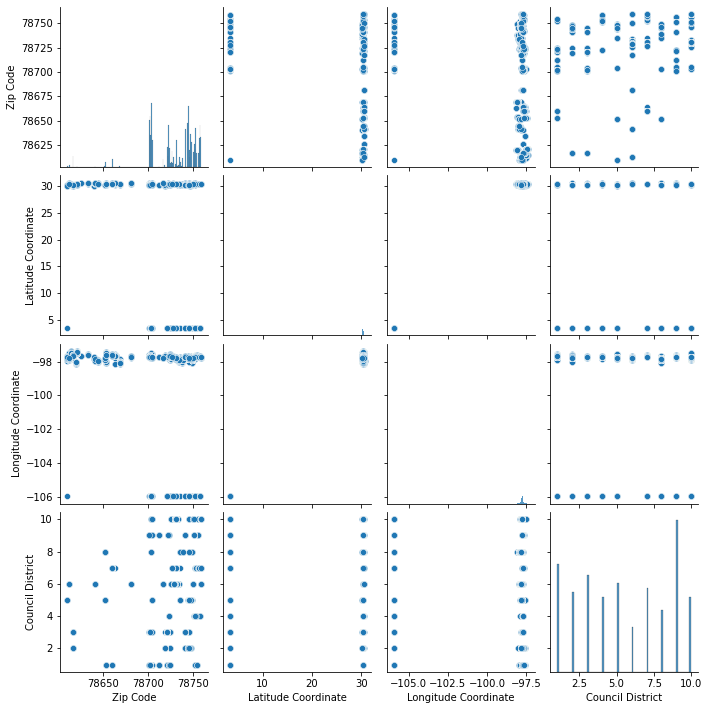

In [15]:
import seaborn as sns

sns.pairplot(df)

In [16]:
# define our variables, we want to determine the status so that is our y, all other factors are treated as independent to that event

date1 = df.loc[:,["Created Date"]]
date2 = df.loc[:,["Closed Date"]]


In [17]:
date1.head()

,Created Date
0,2019-03-14 03:02:15
1,2020-04-07 07:06:32
2,2020-02-12 01:55:04
3,2019-12-10 02:17:04
4,2019-12-10 02:51:24


In [18]:
date2.head()

,Closed Date
0,2020-11-23 01:41:21
1,2020-11-23 12:02:05
2,2020-02-12 12:57:35
3,2019-12-11 09:57:54
4,2019-12-10 03:00:05


In [19]:
def date_list_generator(data):
    app = []
    len(data)
    for i in data:
        for j in data[i]:
            app.append(str(j).replace("-","/")[2:])
    return app


In [20]:
date_1_list = date_list_generator(date1)
date_2_list = date_list_generator(date2)

In [21]:
len(date_1_list) == len(date_2_list)

True

In [22]:
# print(f"First Date:\n\tFormat Check: {date_1_list[200]}\n\tLength Check: {len(date_1_list[200])}")
# print(f"Second Date:\n\tFormat Check: {date_2_list[200]}\n\tLength Check: {len(date_2_list[200])}")

In [23]:
from datetime import datetime

date1_obj = []

for i in range(len(date_1_list)):
    datetime_object_1 = datetime.strptime(date_1_list[i], '%y/%m/%d %H:%M:%S')
    date1_obj.append(datetime_object_1)

In [24]:
date2_obj = []

for i in range(len(date_2_list)):
    if date_2_list[i] == "n": 
        date_2_list[i] = date_2_list[i-1]
    datetime_object_2 = datetime.strptime(date_2_list[i], '%y/%m/%d %H:%M:%S')
    date2_obj.append(datetime_object_2)

In [25]:
date_difference = []
for i in range(len(date_2_list)):
    date_difference.append(date2_obj[i] - date1_obj[i])

In [26]:
# print(date_difference[0:25])

In [27]:
average_timedeltavg = pd.to_timedelta(pd.Series(date_difference)).mean()

In [28]:
print(f"Mean Resolution: {average_timedeltavg}")

Mean Resolution: 33 days 01:34:12.793832299


In [29]:
# for c in date1:
#     a = date1[c][0].replace("-","/")[2:]
#     b = date1[c][1].replace("-","/")[2:]
# print(len(a))    

In [30]:
# from datetime import datetime


# datetime_object_a = datetime.strptime(a, '%y/%m/%d %H:%M:%S')
# datetime_object_b = datetime.strptime(b, '%y/%m/%d %H:%M:%S')
# # datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

In [31]:
# print(f"Date1: {datetime_object_a} \nDate2: {datetime_object_b}")

In [32]:
# c = datetime_object_b - datetime_object_a

In [33]:
# c